In [4]:
#!pip install sentencepiece --quiet
#!pip install sacrebleu --quiet
#!pip install torchdata --quiet

#!pip install --upgrade lxml
## make restart to kernel

In [5]:
#!pip install torchtext
#!pip install einops
#!pip install fastcore
#!pip install fastprogress
#!pip install torcheval
#!pip install umap-learn

In [6]:
import math
from copy import copy
from dataclasses import dataclass
from contextlib import contextmanager
from functools import partial
from collections.abc import Mapping

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchtext.datasets import Multi30k
from tqdm import tqdm
from operator import attrgetter,itemgetter
import fastcore.all as fc
from fastprogress import progress_bar,master_bar
from torcheval.metrics import Mean
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from rotary_embedding.rotary_embedding_torch import RotaryEmbedding

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

/usr/local/lib/python3.9/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

cuda


## Data treparation for tokenizer training

In [7]:
SRC = "de"
TRG = "en"

In [8]:
train_iter = Multi30k(split='train', language_pair=(SRC, TRG))
f_de = open("Multi30k_de_text.txt", "w")
f_en = open("Multi30k_en_text.txt", "w")
for pair in train_iter:
    f_de.write(pair[0]+'\n')
    f_en.write(pair[1]+'\n')
f_de.close()
f_en.close()

In [9]:
en_vocab_size = 8200
de_vocab_size = 10000
vocab_sizes = {"en": en_vocab_size, "de": de_vocab_size}

## train sentencepice models for tokenizers

In [10]:
txt_file1='Multi30k_en_text.txt'
txt_file2='Multi30k_de_text.txt'
model1_prefix='Multi30k_en'
model2_prefix='Multi30k_de'
vocab1_size=8200
vocab2_size=10000
spm.SentencePieceTrainer.train(f'--input={txt_file1} --model_prefix={model1_prefix} --user_defined_symbols=<pad> --vocab_size={vocab1_size}')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=Multi30k_en_text.txt --model_prefix=Multi30k_en --user_defined_symbols=<pad> --vocab_size=8200
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: Multi30k_en_text.txt
  input_format: 
  model_prefix: Multi30k_en
  model_type: UNIGRAM
  vocab_size: 8200
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  p

In [11]:
class Tokenizers:
    def __init__(self, sp1, sp2, vocab1_size, vocab2_size, lang1, lang2, model1_prefix, model2_prefix):
        fc.store_attr()
        self.tokenizers = {lang1: self.sp1.encode_as_ids, self.lang2: self.sp2.encode_as_ids}
        self.detokenizers = {self.lang1: self.sp1.decode_ids, self.lang2: self.sp2.decode_ids}
        
    @classmethod
    def from_files(cls, txt_file1='Multi30k_en_text.txt', txt_file2='Multi30k_de_text.txt', model1_prefix='Multi30k_en',
                   model2_prefix='Multi30k_de', vocab1_size=8200, vocab2_size=10000, lang1="en", lang2="de"):
        spm.SentencePieceTrainer.train(f'--input={txt_file2} --model_prefix={model2_prefix} --user_defined_symbols=<pad> --vocab_size={vocab2_size}')
        spm.SentencePieceTrainer.train(f'--input={txt_file1} --model_prefix={model1_prefix} --user_defined_symbols=<pad> --vocab_size={vocab1_size}')

        # make SentencePieceProcessor instances and load the model files
        sp2 = spm.SentencePieceProcessor()
        sp2.load(f'{model2_prefix}.model')
        sp1 = spm.SentencePieceProcessor()
        sp1.load(f'{model1_prefix}.model')
        
        return cls(sp1=sp1, sp2=sp2, vocab1_size=8200, vocab2_size=10000, lang1=lang1, lang2=lang2, model1_prefix=model1_prefix, model2_prefix=model2_prefix)

tokenizers=Tokenizers.from_files()

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=Multi30k_de_text.txt --model_prefix=Multi30k_de --user_defined_symbols=<pad> --vocab_size=10000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: Multi30k_de_text.txt
  input_format: 
  model_prefix: Multi30k_de
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
 

In [12]:
print(tokenizers.tokenizers["en"]('This is a test'))
print(tokenizers.sp1.encode_as_ids('This is a test'))

[302, 258, 10, 4, 2395]
[302, 258, 10, 4, 2395]


In [13]:
print(tokenizers.sp1.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(tokenizers.sp1.decode_ids([302, 258, 10, 4, 2395]))

▁This is a test
This is a test


In [14]:
print([tokenizers.sp1.id_to_piece(id) for id in range(20)])
print([tokenizers.sp2.id_to_piece(id) for id in range(20)])

['<unk>', '<s>', '</s>', '<pad>', '▁a', '.', '▁A', '▁in', '▁the', '▁on', '▁is', '▁man', '▁and', '▁of', '▁with', 's', 'ing', '▁', ',', '▁woman']
['<unk>', '<s>', '</s>', '<pad>', '.', '▁eine', '▁Ein', 'm', '▁in', '▁mit', ',', '▁und', '▁auf', '▁ein', '▁Mann', '▁einer', '▁Eine', 'n', '▁der', '▁Frau']


## Preporcess data

### tokenize

In [15]:
max_seq_len = 50
def tokenize_dataset(dataset, src, trg, bos_id, eos_id, tokenizers, max_seq_len=50):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    return [(torch.tensor([bos_id]+tokenizers.tokenizers[src](src_text)[0:max_seq_len-2]+[eos_id]),
             torch.tensor([bos_id]+tokenizers.tokenizers[trg](trg_text)[0:max_seq_len-2]+[eos_id]))
            for src_text, trg_text in dataset]

### datasets

In [16]:
class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch, pad_id):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = pad_id)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = pad_id)
    return src_padded, trg_padded

In [17]:
class DataLoaders:
    def __init__(self, unk_id, bos_id, eos_id, pad_id, batch_size, max_seq_len, *dls): 
        self.train, self.valid, self.test = dls[:3]
        self.unk_id, self.bos_id, self.eos_id, self.pad_id=unk_id, bos_id, eos_id, pad_id
        self.batch_size, self.max_seq_len = batch_size, max_seq_len

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        # return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()])
        return cls(*[torch.utils.data.DataLoader(TranslationDataset(ds), batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence,  **kwargs) for ds in dd])
    
    @classmethod
    def from_iters(cls, train_iter, valid_iter, test_iter, src, trg, tokenizers, batch_size=128, max_seq_len=50, as_tuple=True, 
                   unk_id=0, bos_id=1, eos_id=2, pad_id=3, **kwargs):
        train_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in train_iter if x!='']
        valid_set = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in valid_iter if x!='']
        test_set  = [(x.rstrip('\n'), y.rstrip('\n')) for x, y in test_iter if x!='']
        
        train_tokenized = tokenize_dataset(train_set, src, trg, bos_id, eos_id, tokenizers, max_seq_len)
        valid_tokenized = tokenize_dataset(valid_set, src, trg, bos_id, eos_id, tokenizers, max_seq_len)
        test_tokenized  = tokenize_dataset(test_set, src, trg, bos_id, eos_id, tokenizers, max_seq_len)
        pad_sequence_partial=partial(pad_sequence, pad_id=pad_id)
        return cls(unk_id, bos_id, eos_id, pad_id, batch_size, max_seq_len, 
                   *[torch.utils.data.DataLoader(TranslationDataset(ds), batch_size=batch_size,
                                                 shuffle=True, collate_fn = pad_sequence_partial,  **kwargs) \
                     for ds in (train_tokenized, valid_tokenized, test_tokenized)])
        
def get_dls(src, trg, tokenizers, batch_size=128, max_seq_len=50):
    train_iter = Multi30k(split='train', language_pair=(src, trg))
    valid_iter = Multi30k(split='valid', language_pair=(src, trg))
    test_iter  = Multi30k(split='test',  language_pair=(src, trg))
    dls=DataLoaders.from_iters(train_iter, valid_iter, test_iter, src, trg, tokenizers, batch_size, max_seq_len)
    return dls

In [18]:
dls=get_dls(SRC, TRG, tokenizers)

## Model

In [19]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0, use_rot_emb=True):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)
        self.use_rot_emb=use_rot_emb
        if use_rot_emb:
            #self.rotary_emb = RotaryEmbedding(dim = self.d_k//2)
            self.rotary_emb = RotaryEmbedding(dim = self.d_k)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        if self.use_rot_emb:
            query = self.rotary_emb.rotate_queries_or_keys(query)
            key = self.rotary_emb.rotate_queries_or_keys(key)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
    '''residual connection: x + dropout(sublayer(layernorm(x))) '''
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))

# I simply let the model learn the positional embeddings in this notebook, since this 
# almost produces identital results as using sin/cosin functions embeddings, as claimed
# in the original transformer paper. Note also that in the original paper, they multiplied 
# the token embeddings by a factor of sqrt(d_embed), which I do not do here. 

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, inp, mask=None):
        x = self.tok_embed(inp)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout, config.use_rot_emb)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
        self.device=config.device
    
    def future_mask(self, seq_len, device):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(device)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len, self.device))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed, use_rot_emb=config.use_rot_emb)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed, use_rot_emb=config.use_rot_emb)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [20]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    use_rot_emb: bool
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float
    pad_id: int
    unk_id: int
    bos_id: int
    eos_id: int
    device: str

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(config.device)
    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    model.pad_id=config.pad_id
    model.unk_id=config.unk_id
    model.bos_id=config.bos_id
    model.eos_id=config.eos_id
    return model

## Callbacks

In [21]:
class CancelFitException(Exception): 
    pass
class CancelBatchException(Exception): 
    pass
class CancelEpochException(Exception): 
    pass

class Callback(): 
    order = 0
    
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: 
            # print(method)
            method(learn)

## Learner

In [22]:
def make_batch_input(batch, device, pad_id):
    x, y = batch[0], batch[1]
    src = x.to(device)
    trg_in = y[:, :-1].to(device)
    trg_out = y[:, 1:].contiguous().view(-1).to(device)
    src_pad_mask = (src == pad_id).view(src.size(0), 1, 1, src.size(-1))
    trg_pad_mask = (trg_in == pad_id).view(trg_in.size(0), 1, 1, trg_in.size(-1))
    return {'src':src, 'trg_in':trg_in, 'trg_out':trg_out, 'src_pad_mask':src_pad_mask, 'trg_pad_mask':trg_pad_mask}
    
    
class TrainCB(Callback):
    def __init__(self, grad_acc_steps=1):
        super(Callback, self).__init__()
        fc.store_attr()
        
    def predict(self, learn): 
        learn.batch = make_batch_input(learn.batch, learn.device, learn.model.pad_id)
        preds = learn.model(learn.batch['src'], learn.batch['src_pad_mask'], learn.batch['trg_in'], learn.batch['trg_pad_mask'])
        learn.preds = preds.view(-1, preds.size(-1))
        
    def get_loss(self, learn):
        learn.loss_func(learn)
        
    def backward(self, learn):
        learn.loss.backward()
            
    def step(self, learn): 
        learn.opt.step()
        
    def zero_grad(self, learn):
        learn.opt.zero_grad()

In [23]:
class Learner():
    def __init__(self, model, dls, loss_func=None, lr=0.1, cbs=None, device='cuda', opt_func=torch.optim.Adam):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def callback_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: 
            pass
        finally: 
            self.callback(f'cleanup_{nm}')

    def one_epoch(self, train):
        self.model.train(train)
        
        self.dl = self.dls.train if train else self.dls.valid
        # pdb.set_trace()
        with self.callback_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.callback('after_predict')
                    self.get_loss()
                    self.callback('after_loss')
                    if self.training:
                        self.backward()
                        self.callback('after_loss')
                        self.step()
                        self.callback('after_step')
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=False, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: 
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            # pdb.set_trace()
            with self.callback_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: 
                        self.one_epoch(True)
                    if valid: 
                        torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: 
                self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): 
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): 
        run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): 
        return self.model.training

## Progress cb

In [24]:
def to_cpu(x):
    if isinstance(x, Mapping): 
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): 
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple): 
        return tuple(to_cpu(list(x)))
    return x.detach().cpu()


class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: 
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        
    def _log(self, d): 
        print(d)
        
    def before_fit(self, learn): 
        learn.metrics = self
        
    def before_epoch(self, learn): 
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        batch = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            m.update(to_device(batch), learn)
        self.loss.update(to_cpu(learn.loss), weight=len(batch))
        
        
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): 
            learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): 
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
        
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

## Loss calc

In [25]:
class CustomLoss():
    def __init__(self, loss_fun):
        self.loss_fun=loss_fun()

    def calc_loss(self, learn): 
        trg_out=learn.batch['trg_out']
        loss=self.loss_fun(learn.preds, trg_out)
        learn.loss = loss

## Gradient clipping

In [26]:
class GradientClipping(Callback):
    order=2
    def __init__(self, grad_norm_clip=1.0):
        self.grad_norm_clip=grad_norm_clip
        
    def after_loss(self, learn):
        torch.nn.utils.clip_grad_norm_(learn.model.parameters(), self.grad_norm_clip)

## Scheduler

In [27]:
class BaseSchedCB(Callback):
    def __init__(self, sched): 
        self.sched = sched
        self.lrs=[]
        
    def before_fit(self, learn): 
        self.schedo = self.sched(learn.opt)
        
    def step_(self, learn):
        if learn.training: 
            self.schedo.step()
            self.lrs.append(self.schedo.get_last_lr()[0])
        
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn):
        self.step_(learn) 
        
        
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn):
        if learn.training: 
            self.step_(learn) 

## Set parameters and callbacks for training

In [28]:
#dataloaders
batch_size = 128
max_seq_len=50
dls=get_dls(SRC, TRG, tokenizers, batch_size, max_seq_len)

# #model config
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC], 
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     use_rot_emb=True,
                     d_ff=512, 
                     h=8,
                     N_encoder=3, 
                     N_decoder=3, 
                     max_seq_len=max_seq_len,
                     dropout=0.1,
                     pad_id=dls.pad_id,
                     unk_id=dls.unk_id,
                     bos_id=dls.bos_id,
                     eos_id=dls.eos_id,
                     device='cuda')

model = make_model(config)

#optimizer
lr=0.5
optimizer_func = partial(torch.optim.Adam, betas=(0.9, 0.98), eps=1e-9)

#lr scheduler
warmup_steps = 3*len(dls.train)
# lr first increases in the warmup steps, and then decreases
lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])  
lr_scheduler = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lr_fn)
#loss
loss_cl=CustomLoss(partial(nn.CrossEntropyLoss, ignore_index=dls.pad_id))
loss_func=loss_cl.calc_loss

grad_norm_clip = 1.0

In [29]:
#init callbacks
cbs = [TrainCB(),
       BatchSchedCB(lr_scheduler), 
       GradientClipping(grad_norm_clip),
       MetricsCB(),
       ProgressCB(plot=True)]

In [30]:
learner = Learner(model, dls, loss_func, lr, cbs, opt_func=optimizer_func)

## Train model

loss,epoch,train
5.506,0,train
3.539,0,eval
2.918,1,train
2.380,1,eval
2.056,2,train
1.949,2,eval
1.614,3,train
1.758,3,eval
1.290,4,train
1.707,4,eval


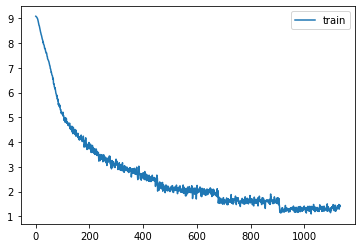

In [31]:
N_epochs=5
learner.fit(N_epochs, valid=True)

## Comparison model without rotary embedding

In [32]:
dls=get_dls(SRC, TRG, tokenizers, batch_size, max_seq_len)
# #model config
config_no_rot = ModelConfig(encoder_vocab_size = vocab_sizes[SRC], 
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     use_rot_emb=False,
                     d_ff=512, 
                     h=8,
                     N_encoder=3, 
                     N_decoder=3, 
                     max_seq_len=max_seq_len,
                     dropout=0.1,
                     pad_id=dls.pad_id,
                     unk_id=dls.unk_id,
                     bos_id=dls.bos_id,
                     eos_id=dls.eos_id,
                     device='cuda')

model_no_rot = make_model(config_no_rot)

#lr scheduler
warmup_steps = 3*len(dls.train)
# lr first increases in the warmup steps, and then decreases
lr_fn_norot = lambda step: config_no_rot.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])  
lr_scheduler_no_rot = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lr_fn_norot)

In [33]:
#init callbacks
cbs_norot = [TrainCB(),
       BatchSchedCB(lr_scheduler_no_rot), 
       GradientClipping(grad_norm_clip),
       MetricsCB(),
       ProgressCB(plot=True)]

In [34]:
learner_no_rot = Learner(model_no_rot, dls, loss_func, lr, cbs_norot, opt_func=optimizer_func)

loss,epoch,train
5.539,0,train
3.702,0,eval
3.078,1,train
2.550,1,eval
2.215,2,train
2.104,2,eval
1.749,3,train
1.883,3,eval
1.400,4,train
1.796,4,eval


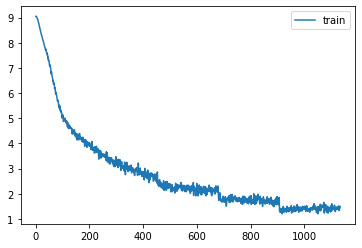

In [35]:
N_epochs=5
learner_no_rot.fit(N_epochs, valid=True)

## Evaluate model scores

In [36]:
model=model.eval()

In [37]:
def translate(model, x, pad_id, device='cuda'):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[model.bos_id]*dB]).view(dB, 1).to(device)
        x_pad_mask = (x == model.pad_id).view(x.size(0), 1, 1, x.size(-1)).to(device)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == pad_id).view(y.size(0), 1, 1, y.size(-1)).to(device)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(device)
    return y

def remove_pad(sent, eos_id, pad_id):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(eos_id)>0:
        sent = sent[0:sent.index(eos_id)+1]
    while sent and sent[-1] == pad_id:
        sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids, eos_id, pad_id):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids, eos_id, pad_id)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, eos_id, pad_id, src_lang, trg_lang, detokenizers, num_batch=None, device='cuda'):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            batch = make_batch_input([x, y], device, pad_id)
            translation = translate(model, batch["src"], pad_id)
            batch["trg_out"] = batch["trg_out"].view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[trg_lang], batch['trg_out'][i], eos_id, pad_id) for i in range(len(batch["src"]))]
            cans = cans + [decode_sentence(detokenizers[trg_lang], translation[i], eos_id, pad_id) for i in range(len(batch["src"]))] 
            if num_batch and idx>=num_batch:
                break
        print(min([len(x) for x in refs]))
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[src_lang], batch["src"][i], eos_id, pad_id)}')
            print(f'trg:  {decode_sentence(detokenizers[trg_lang], batch["trg_out"][i], eos_id, pad_id)}')
            print(f'pred: {decode_sentence(detokenizers[trg_lang], translation[i], eos_id, pad_id)}')
        return np.mean(bleus)

In [38]:
print("train set examples:")
train_bleu = evaluate(model, dls.train, model.eos_id, model.pad_id, SRC, TRG, tokenizers.detokenizers, 20)
print("validation set examples:")
valid_bleu = evaluate(model, dls.valid, model.eos_id, model.pad_id, SRC, TRG, tokenizers.detokenizers)
print("test set examples:")
test_bleu  = evaluate(model, dls.test, model.eos_id, model.pad_id, SRC, TRG, tokenizers.detokenizers)

train set examples:
22
src:  Zwei Männer kämpfen bei einem Fußballspiel um den Ball.
trg:  Two men are competing for the ball in a game of soccer.
pred: Two men are fighting over the ball during a soccer game.
src:  Ein frisch verheiratetes Paar tanzt und hat Geld auf der Kleidung.
trg:  A newly married couple dances with money on their clothes.
pred: A newly married couple dances with money on their clothes.
src:  Eine Gruppe von Kindern spielt mit Requisiten.
trg:  A group of children playing with props
pred: A group of children playing with a mannequin.
validation set examples:
20
src:  Zwei Teams, eines davon in Pink und eines in Weiß, spielen Lacrosse auf einem Sportplatz.
trg:  Two teams, one in pink and one in white, play lacrosse on a field.
pred: Two teams, one of whis of whis and one wearing white, play lacrosse on a sports field.
src:  Bauarbeiter stehen auf einer Maschine
trg:  Construction workers standing on top of a piece of machinery.
pred: Construction workers are stan

In [39]:
train_bleu

44.14587719150505

In [40]:
test_bleu

36.752866443990875

In [41]:
valid_bleu

36.40544217751185

In [42]:
#compare with model without rotary embedding
print("train set examples:")
train_bleu_no_rot = evaluate(model_no_rot, dls.train, model_no_rot.eos_id, model_no_rot.pad_id, SRC, TRG, tokenizers.detokenizers, 20)
print("validation set examples:")
valid_bleu_no_rot = evaluate(model_no_rot, dls.valid, model_no_rot.eos_id, model_no_rot.pad_id, SRC, TRG, tokenizers.detokenizers)
print("test set examples:")
test_bleu_no_rot  = evaluate(model_no_rot, dls.test, model_no_rot.eos_id, model_no_rot.pad_id, SRC, TRG, tokenizers.detokenizers)

train set examples:
15
src:  Ein kleiner Junge klettert auf einen großen weißen schlafenden Hund.
trg:  A boy toddler climbs on a big white sleeping dog.
pred: A little boy climbs a large white sleeping dog.
src:  Zwei Erwachsene mit Helm albern herum, im Hintergrund Berglandschaft.
trg:  Two adults in helmets are fooling around with mountainous terrain in the background.
pred: Two adults in a helmet with mountain mountains in the background.
src:  Eine Dame steht in einer Küche vor dem Herd und brät etwas in einer Bratpfanne.
trg:  A lady in a kitchen is standing in front of the stove frying something in a frying pan.
pred: A lady stands in a kitchen in front of the stove, frying something in a pan.
validation set examples:
20
src:  Ein Mann und eine Frau überqueren eine leere Straße.
trg:  A man and woman walk across an empty street.
pred: A man and woman are crossing an empty street.
src:  Ein Mann in einem schwarzen T-Shirt und braunen Cargohosen hält eine Schaufel über seinem Kopf

In [43]:
train_bleu_no_rot

42.601482734890475

In [44]:
test_bleu_no_rot

34.7211569389873

In [45]:
valid_bleu_no_rot

35.21594396383609

## Translate your sentences

In [46]:
def translate(model, x, device):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[model.bos_id]*dB]).view(dB, 1).to(device)
        x_pad_mask = (x == model.pad_id).view(x.size(0), 1, 1, x.size(-1)).to(device)
        memory = model.encoder(x, x_pad_mask).to(device)
        for i in range(max_seq_len):
            y_pad_mask = (y == model.pad_id).view(y.size(0), 1, 1, y.size(-1)).to(device)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(device)
    return y

def translate_this_sentence(text: str, model, tokenizers, src, trg, device='cuda'):
    'translate the source sentence in string formate into target language'
    inp = torch.tensor([[model.bos_id] + tokenizers.tokenizers[src](text) + [model.eos_id]]).to(device)
    output = translate(model, inp, device)
    return decode_sentence(tokenizers.detokenizers[trg], output[0], model.eos_id, model.pad_id)

In [47]:
translate_this_sentence("Eine Gruppe von Menschen steht vor einem Iglu.", model, tokenizers, SRC, TRG)

'A group of people are standing in front of an I igloo.'

## Visualizing rotary embedding

In [48]:
def get_embs(x_inp, model, device='cuda'):
    with torch.no_grad():
        x_inp=x_inp.to(device)
        x = model.encoder.tok_embed(x_inp)
        x_pos = model.encoder.pos_embed[:, :x.size(1), :]
        nbatch=1
        query = model.encoder.encoder_blocks[0].atten.WQ(x_pos).view(nbatch, -1, model.encoder.encoder_blocks[0].atten.h, model.encoder.encoder_blocks[0].atten.d_k).transpose(1,2)
        key   = model.encoder.encoder_blocks[0].atten.WK(x_pos).view(nbatch, -1, model.encoder.encoder_blocks[0].atten.h, model.encoder.encoder_blocks[0].atten.d_k).transpose(1,2)
        value = model.encoder.encoder_blocks[0].atten.WV(x_pos).view(nbatch, -1, model.encoder.encoder_blocks[0].atten.h, model.encoder.encoder_blocks[0].atten.d_k).transpose(1,2)

        query_rot = model.encoder.encoder_blocks[0].atten.rotary_emb.rotate_queries_or_keys(query)
        key_rot = model.encoder.encoder_blocks[0].atten.rotary_emb.rotate_queries_or_keys(key)
    return query.to('cpu').detach().numpy(), query_rot.to('cpu').detach().numpy(), key.to('cpu').detach().numpy(), key_rot.to('cpu').detach().numpy(), value.to('cpu').detach().numpy()

In [49]:
##convert to 2-d for visualization
#def reduce_dims(emb):
  #  reducer = umap.UMAP()
   # emb_reduced = reducer.fit_transform(emb)
    #return emb_reduced, reducer

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [101]:
#take sample from test data
x_inp, y=next(iter(dls.test))
x_inp=x_inp.to('cuda')
x_inp.shape

torch.Size([128, 40])

In [102]:
#get embeddings with an wo rotation
query, query_rot, key, key_rot, value =get_embs(x_inp, model)

<AxesSubplot:>

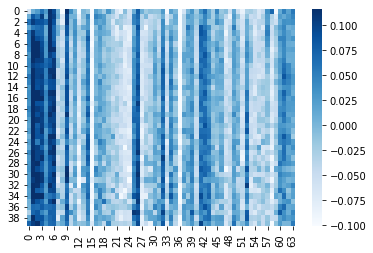

In [103]:
#see differences or original and rotated embeddings
i=3
sns.heatmap(query[0][i], cmap='Blues', robust=True)

<AxesSubplot:>

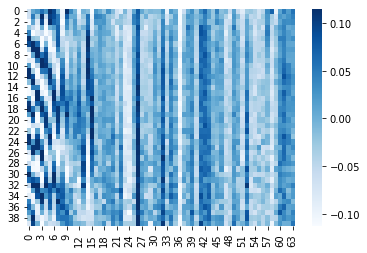

In [104]:
sns.heatmap(query_rot[0][i], cmap='Blues', robust=True)

<AxesSubplot:>

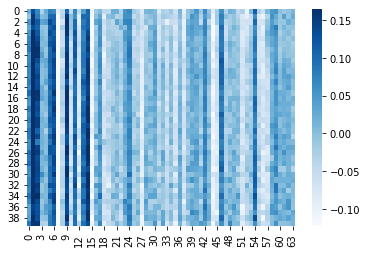

In [105]:
sns.heatmap(key[0][i], cmap='Blues', robust=True)

<AxesSubplot:>

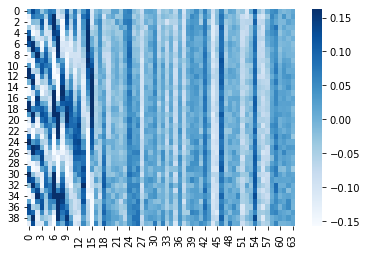

In [106]:
sns.heatmap(key_rot[0][i], cmap='Blues', robust=True)

In [107]:
#angle between query and key has not changed after rotation
idx=20 #index of query/key element
angle_between(key[0][i][idx,:], query[0][i][idx,:])

1.0894800615801432

In [108]:
angle_between(key_rot[0][i][idx,:], query_rot[0][i][idx,:])

1.0894801288246863

In [109]:
#also magnitude has not changed after rotation
np.linalg.norm(query[0]), np.linalg.norm(query_rot[0])

(7.9047813, 7.904781)

In [110]:
np.linalg.norm(key[0]), np.linalg.norm(key_rot[0])

(9.5816, 9.581601)

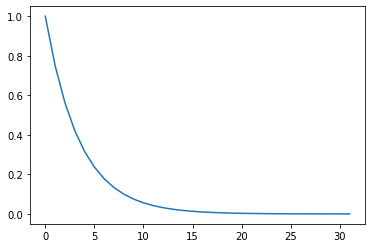

In [111]:
#we can see the original "frequencies" used to rotate embeddings based on the element index in embedding vector 
#initial elements get more changed than latter ones as could be seen in the previous heatmaps where initial 
#elements have bigger changes than latter ones which are the same
plt.plot(model.encoder.encoder_blocks[0].atten.rotary_emb.freqs.detach().cpu().numpy())

In [146]:
query.shape

(1, 8, 40, 64)

In [147]:
#see rotation matrix, dervied from previous freqs
seq_len=query.shape[-2]
t = lambda: torch.arange(seq_len, device = 'cuda')
t=t() #positional indexes
freqs = model.encoder.encoder_blocks[0].atten.rotary_emb.freqs
freqs = torch.einsum('..., f -> ... f', t.type(freqs.dtype), freqs)

In [148]:
freqs.shape

torch.Size([40, 32])

<AxesSubplot:>

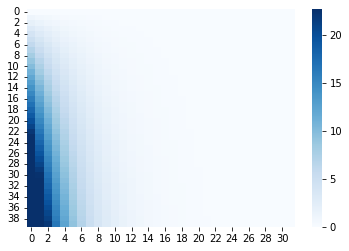

In [149]:
sns.heatmap(freqs.detach().cpu().numpy(), cmap='Blues', robust=True)

<AxesSubplot:>

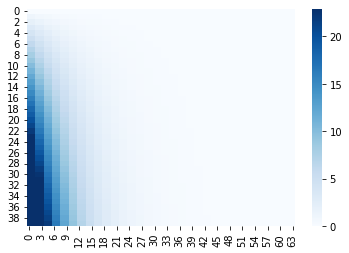

In [150]:
#repeat to get original dimensions
from einops import repeat, rearrange
freqs_rep = repeat(freqs, '... n -> ... (n r)', r = 2)
sns.heatmap(freqs_rep.detach().cpu().numpy(), cmap='Blues', robust=True)

In [153]:
def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

In [160]:
#apply rotation
start_index=0
rot_dim = freqs_rep.shape[-1]
end_index = start_index + rot_dim
t=torch.tensor(query).to(DEVICE) #note here t is a bit different then previously, we'll rotate a query
assert rot_dim <= t.shape[-1], f'feature dimension {t.shape[-1]} is not of sufficient size to rotate in all the positions {rot_dim}'
t_left, t, t_right = t[..., :start_index], t[..., start_index:end_index], t[..., end_index:]
scale=1.0
t = (t * freqs_rep.cos() * scale) + (rotate_half(t) * freqs_rep.sin() * scale) #formula 34 on paper 
#"ROFORMER: ENHANCED TRANSFORMER WITH ROTARY POSITION EMBEDDING"  

In [162]:
t.shape

torch.Size([1, 8, 40, 64])

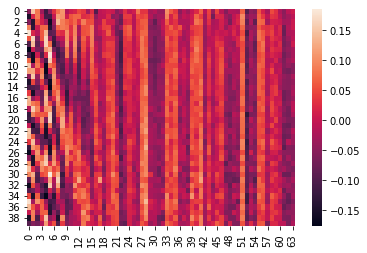

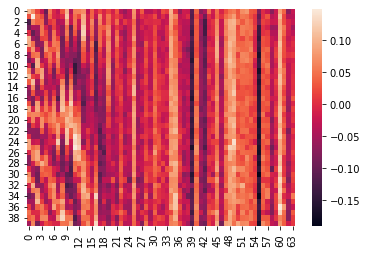

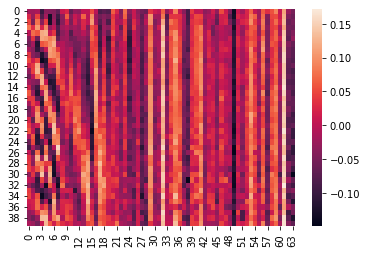

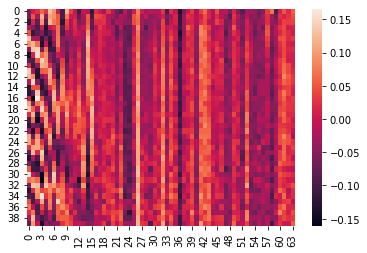

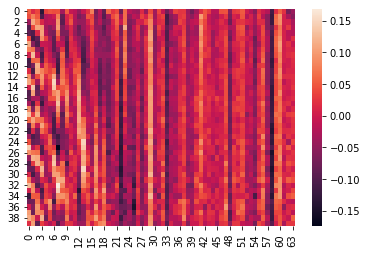

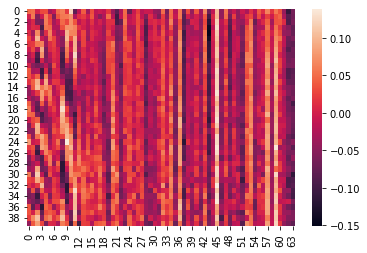

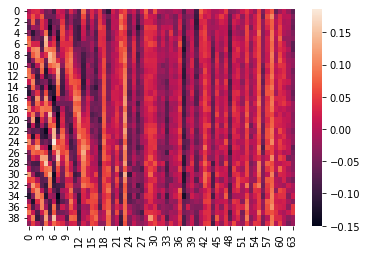

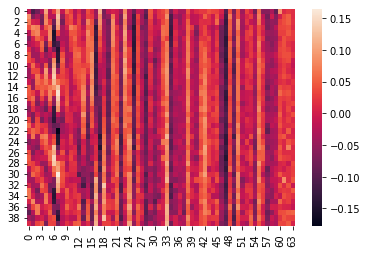

In [163]:
# plotrotations of all of the heads
for i in range(t.shape[1]):
    sns.heatmap(t[0][i].detach().cpu().numpy())
    plt.show()